# We will run the same NPT simulation respectively on 1GPU, 2GPU and 4GPU, to compare the performance.

In [1]:
import json
from time import time as timer
import jax
import openferro as of
from openferro.engine.elastic import *
from openferro.engine.ferroelectric import *
from openferro.units import Constants
from openferro.parallelism import DeviceMesh
from IPython.display import clear_output

##########################################################################################
## Define the lattice  (256X256X256 Simple Cubic Lattice)
##########################################################################################
L = 256
hydropres =  -4.8e4   ## apply a hydrostatic pressure to correct for error of DFT approximation used to parameterize the lattice model. 
config = json.load(open('BaTiO3.json'))
latt_vecs = jnp.eye(3) * config['lattice']['a1']
latt = of.SimpleCubic3D(L, L, L, latt_vecs[0], latt_vecs[1], latt_vecs[2])


## First run the simulation on 1 GPU. 

In [2]:
bto = of.System(latt)
##########################################################################################
## Define the fields
##########################################################################################
dipole_field = bto.add_field(ID="dipole", ftype="Rn", dim=3, value=0.0, mass = 200 * Constants.amu)
lstrain_field = bto.add_field(ID="lstrain", ftype="LocalStrain3D", value=0.0, mass = 200 * Constants.amu)
gstrain  = bto.add_global_strain(value=jnp.array([0.01,0.01,0.01,0,0,0]), mass = 200 * Constants.amu * L**3)

##########################################################################################
## Define the Hamiltonian
##########################################################################################
bto.add_dipole_onsite_interaction('self_onsite', field_ID="dipole", K2=config["onsite"]["k2"], alpha=config["onsite"]["alpha"], gamma=config["onsite"]["gamma"])
bto.add_dipole_interaction_1st_shell('short_range_1', field_ID="dipole", j1=config["short_range"]["j1"], j2=config["short_range"]["j2"])
bto.add_dipole_interaction_2nd_shell('short_range_2', field_ID="dipole", j3=config["short_range"]["j3"], j4=config["short_range"]["j4"], j5=config["short_range"]["j5"])
bto.add_dipole_interaction_3rd_shell('short_range_3', field_ID="dipole", j6=config["short_range"]["j6"], j7=config["short_range"]["j7"])
bto.add_dipole_dipole_interaction('dipole_ewald', field_ID="dipole", prefactor = config["born"]["Z_star"]**2 / config["born"]["epsilon_inf"] )
bto.add_homo_elastic_interaction('homo_elastic', field_ID="gstrain", B11=config["elastic"]["B11"], B12=config["elastic"]["B12"], B44=config["elastic"]["B44"])
bto.add_homo_strain_dipole_interaction('homo_strain_dipole', field_1_ID="gstrain", field_2_ID="dipole", B1xx=config["elastic_dipole"]["B1xx"], B1yy=config["elastic_dipole"]["B1yy"], B4yz=config["elastic_dipole"]["B4yz"])
bto.add_inhomo_elastic_interaction('inhomo_elastic', field_ID="lstrain", B11=config["elastic"]["B11"], B12=config["elastic"]["B12"], B44=config["elastic"]["B44"])
bto.add_inhomo_strain_dipole_interaction('inhomo_strain_dipole', field_1_ID="lstrain", field_2_ID="dipole", B1xx=config["elastic_dipole"]["B1xx"], B1yy=config["elastic_dipole"]["B1yy"], B4yz=config["elastic_dipole"]["B4yz"])

##########################################################################################
## NPT simulation setup
##########################################################################################
dt = 0.002
temperature = 300
dipole_field.set_integrator('isothermal', dt=dt, temp=temperature, tau=0.1)
lstrain_field.set_integrator('isothermal', dt=dt, temp=temperature, tau=1)
gstrain.set_integrator('isothermal', dt=dt, temp=temperature, tau=1)
simulation = of.SimulationNPTLangevin(bto, pressure=hydropres)
simulation.init_velocity(mode='gaussian', temp=temperature)

##########################################################################################
## Run
##########################################################################################
t0_1gpu_init = timer()
jax.block_until_ready(simulation.run(1, profile=False))
t1_1gpu_init = timer()

t0_1gpu_run = timer()
jax.block_until_ready(simulation.run(500, profile=False))
t1_1gpu_run = timer()

##########################################################################################
## Report
##########################################################################################
clear_output()   # Clean the "constant folding warning" from JAX. It is expected for large lattices.

print(f"initialization takes: {t1_1gpu_init-t0_1gpu_init} seconds")
print(f"500 steps takes: {t1_1gpu_run-t0_1gpu_run} seconds")

initialization takes: 228.53161883354187 seconds
500 steps takes: 51.456912994384766 seconds


## Run the same simulation on 2 GPUs

In [3]:
bto = of.System(latt)
##########################################################################################
## Define the fields
##########################################################################################
dipole_field = bto.add_field(ID="dipole", ftype="Rn", dim=3, value=0.0, mass = 200 * Constants.amu)
lstrain_field = bto.add_field(ID="lstrain", ftype="LocalStrain3D", value=0.0, mass = 200 * Constants.amu)
gstrain  = bto.add_global_strain(value=jnp.array([0.01,0.01,0.01,0,0,0]), mass = 200 * Constants.amu * L**3)

##########################################################################################
## move fields to multi-GPUs
##########################################################################################
gpu_mesh = DeviceMesh(jax.devices()[:2], num_rows=2, num_cols=1)
bto.move_fields_to_multi_devs(gpu_mesh)

##########################################################################################
## Define the Hamiltonian
##########################################################################################
bto.add_dipole_onsite_interaction('self_onsite', field_ID="dipole", K2=config["onsite"]["k2"], alpha=config["onsite"]["alpha"], gamma=config["onsite"]["gamma"])
bto.add_dipole_interaction_1st_shell('short_range_1', field_ID="dipole", j1=config["short_range"]["j1"], j2=config["short_range"]["j2"])
bto.add_dipole_interaction_2nd_shell('short_range_2', field_ID="dipole", j3=config["short_range"]["j3"], j4=config["short_range"]["j4"], j5=config["short_range"]["j5"])
bto.add_dipole_interaction_3rd_shell('short_range_3', field_ID="dipole", j6=config["short_range"]["j6"], j7=config["short_range"]["j7"])
bto.add_dipole_dipole_interaction('dipole_ewald', field_ID="dipole", prefactor = config["born"]["Z_star"]**2 / config["born"]["epsilon_inf"] )
bto.add_homo_elastic_interaction('homo_elastic', field_ID="gstrain", B11=config["elastic"]["B11"], B12=config["elastic"]["B12"], B44=config["elastic"]["B44"])
bto.add_homo_strain_dipole_interaction('homo_strain_dipole', field_1_ID="gstrain", field_2_ID="dipole", B1xx=config["elastic_dipole"]["B1xx"], B1yy=config["elastic_dipole"]["B1yy"], B4yz=config["elastic_dipole"]["B4yz"])
bto.add_inhomo_elastic_interaction('inhomo_elastic', field_ID="lstrain", B11=config["elastic"]["B11"], B12=config["elastic"]["B12"], B44=config["elastic"]["B44"])
bto.add_inhomo_strain_dipole_interaction('inhomo_strain_dipole', field_1_ID="lstrain", field_2_ID="dipole", B1xx=config["elastic_dipole"]["B1xx"], B1yy=config["elastic_dipole"]["B1yy"], B4yz=config["elastic_dipole"]["B4yz"])

##########################################################################################
## NPT simulation setup
##########################################################################################
dt = 0.002
temperature = 300
dipole_field.set_integrator('isothermal', dt=dt, temp=temperature, tau=0.1)
lstrain_field.set_integrator('isothermal', dt=dt, temp=temperature, tau=1)
gstrain.set_integrator('isothermal', dt=dt, temp=temperature, tau=1)
simulation = of.SimulationNPTLangevin(bto, pressure=hydropres)
simulation.init_velocity(mode='gaussian', temp=temperature)

##########################################################################################
## Run
##########################################################################################
t0_2gpu_init = timer()
jax.block_until_ready(simulation.run(1, profile=False))
t1_2gpu_init = timer()

t0_2gpu_run = timer()
jax.block_until_ready(simulation.run(500, profile=False))
t1_2gpu_run = timer()

##########################################################################################
## Report
##########################################################################################
clear_output()   # Clean the "constant folding warning" from JAX. It is expected for large lattices.

print(f"initialization takes: {t1_2gpu_init-t0_2gpu_init} seconds")
print(f"500 steps takes: {t1_2gpu_run-t0_2gpu_run} seconds")

initialization takes: 225.68468475341797 seconds
500 steps takes: 28.956359148025513 seconds


## Run the same simulation on 4 GPUs

In [5]:
bto = of.System(latt)
##########################################################################################
## Define the fields
##########################################################################################
dipole_field = bto.add_field(ID="dipole", ftype="Rn", dim=3, value=0.0, mass = 200 * Constants.amu)
lstrain_field = bto.add_field(ID="lstrain", ftype="LocalStrain3D", value=0.0, mass = 200 * Constants.amu)
gstrain  = bto.add_global_strain(value=jnp.array([0.01,0.01,0.01,0,0,0]), mass = 200 * Constants.amu * L**3)

##########################################################################################
## move fields to multi-GPUs
##########################################################################################
gpu_mesh = DeviceMesh(jax.devices()[:4], num_rows=2, num_cols=2)
bto.move_fields_to_multi_devs(gpu_mesh)

##########################################################################################
## Define the Hamiltonian
##########################################################################################
bto.add_dipole_onsite_interaction('self_onsite', field_ID="dipole", K2=config["onsite"]["k2"], alpha=config["onsite"]["alpha"], gamma=config["onsite"]["gamma"])
bto.add_dipole_interaction_1st_shell('short_range_1', field_ID="dipole", j1=config["short_range"]["j1"], j2=config["short_range"]["j2"])
bto.add_dipole_interaction_2nd_shell('short_range_2', field_ID="dipole", j3=config["short_range"]["j3"], j4=config["short_range"]["j4"], j5=config["short_range"]["j5"])
bto.add_dipole_interaction_3rd_shell('short_range_3', field_ID="dipole", j6=config["short_range"]["j6"], j7=config["short_range"]["j7"])
bto.add_dipole_dipole_interaction('dipole_ewald', field_ID="dipole", prefactor = config["born"]["Z_star"]**2 / config["born"]["epsilon_inf"] )
bto.add_homo_elastic_interaction('homo_elastic', field_ID="gstrain", B11=config["elastic"]["B11"], B12=config["elastic"]["B12"], B44=config["elastic"]["B44"])
bto.add_homo_strain_dipole_interaction('homo_strain_dipole', field_1_ID="gstrain", field_2_ID="dipole", B1xx=config["elastic_dipole"]["B1xx"], B1yy=config["elastic_dipole"]["B1yy"], B4yz=config["elastic_dipole"]["B4yz"])
bto.add_inhomo_elastic_interaction('inhomo_elastic', field_ID="lstrain", B11=config["elastic"]["B11"], B12=config["elastic"]["B12"], B44=config["elastic"]["B44"])
bto.add_inhomo_strain_dipole_interaction('inhomo_strain_dipole', field_1_ID="lstrain", field_2_ID="dipole", B1xx=config["elastic_dipole"]["B1xx"], B1yy=config["elastic_dipole"]["B1yy"], B4yz=config["elastic_dipole"]["B4yz"])

##########################################################################################
## NPT simulation setup
##########################################################################################
dt = 0.002
temperature = 300
dipole_field.set_integrator('isothermal', dt=dt, temp=temperature, tau=0.1)
lstrain_field.set_integrator('isothermal', dt=dt, temp=temperature, tau=1)
gstrain.set_integrator('isothermal', dt=dt, temp=temperature, tau=1)
simulation = of.SimulationNPTLangevin(bto, pressure=hydropres)
simulation.init_velocity(mode='gaussian', temp=temperature)

##########################################################################################
## Run
##########################################################################################
t0_4gpu_init = timer()
jax.block_until_ready(simulation.run(1, profile=False))
t1_4gpu_init = timer()

t0_4gpu_run = timer()
jax.block_until_ready(simulation.run(500, profile=False))
t1_4gpu_run = timer()

##########################################################################################
## Report
##########################################################################################
clear_output()   # Clean the "constant folding warning" from JAX. It is expected for large lattices.

print(f"initialization takes: {t1_4gpu_init-t0_4gpu_init} seconds")
print(f"500 steps takes: {t1_4gpu_run-t0_4gpu_run} seconds")

initialization takes: 226.28097200393677 seconds
500 steps takes: 20.941428661346436 seconds


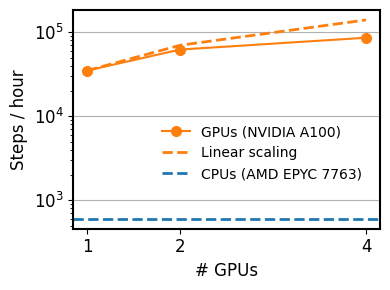

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12


## Machine info: Four NVIDIA A100-SXM4-40GB      Driver Version: 560.35.05      CUDA Version: 12.6

ngpu = np.array([1,2,4])
t = np.array([51.456912994384766, 28.956359148025513, 20.941428661346436])
t_cpu = 596.919350862503  # 100 steps, AMD EPYC 7763 64-Core Processor

nsteps_per_hour = 3600/t*500
nsteps_per_hour_cpu = 3600/t_cpu*100
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(ngpu, nsteps_per_hour, marker='o', label='GPUs (NVIDIA A100)', markersize=7, color='tab:orange')
ax.plot(ngpu, nsteps_per_hour[0] * ngpu, color='tab:orange', linestyle='dashed', linewidth=2, label='Linear scaling')
ax.set_xticks(ngpu)
ax.set_yscale('log')
ax.set_xlabel('# GPUs')
ax.set_ylabel('Steps / hour')
## add grid
ax.grid(True, axis='y')
ax.axhline(nsteps_per_hour_cpu, color='tab:blue', linestyle='dashed', linewidth=2, label='CPUs (AMD EPYC 7763)')
ax.legend(frameon=False, loc='lower left', fontsize=10, bbox_to_anchor=(0.25, 0.16))
plt.tight_layout()
plt.savefig('GPU_benchmark.png', dpi=300)


